# Project 6 - IMDB Movie Ratings - API & Random Forests

We will try to determine which factors influence a movie's success in the form of their rating on imdb.  
We will collect data on the top 250 IMDB movies (such as gross, academy awards won, year, etc.) and build a tree model to predict a movie score (as a continuous variable) and to understand which factors are the most influential.  
We will test several tree models and compare their cross validated r2 scores to use the most efficient one.  
Based on the most efficient model, we will then extract its most influential features.  

In [1]:
from __future__ import division, unicode_literals
import pandas as pd
import numpy as np
import requests
import re
import json
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option("display.max_columns", 100)

## 1. Get the data

In [2]:
#Extract the top 250 movies id and store them in a list
response = requests.get('http://www.imdb.com/chart/top')
html = response.text
raw_entries = re.findall('<a href="/title/(.*?)"\ntitle=(.*?)</a>', html)
entries = [i[0][:9] for i in raw_entries]
entries[:5]

[u'tt0111161', u'tt0068646', u'tt0071562', u'tt0468569', u'tt0050083']

In [3]:
#Define function that gets movie info from OMDB API from the movie id
def get_entry(entry):
    res = requests.get('http://www.omdbapi.com/?i='+entry)
    #Check http request has succeeded (status code =200), if not print status code.
    if res.status_code != 200:
        print entry, res.status_code

    #Decode JSON from request
    try:
        j = json.loads(res.text)
    except ValueError:
        j = None
    return j

In [4]:
#Get info for top 250 movies and store in a list
entries_dict_list = [get_entry(e) for e in entries]

In [5]:
len(entries_dict_list)

250

In [6]:
top_250 = pd.DataFrame(entries_dict_list)
top_250.head(2)

,Actors,Awards,Country,Director,Genre,Language,Metascore,Plot,Poster,Rated,Released,Response,Runtime,Title,Type,Writer,Year,imdbID,imdbRating,imdbVotes
0,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",Nominated for 7 Oscars. Another 19 wins & 30 n...,USA,Frank Darabont,"Crime, Drama",English,80,Two imprisoned men bond over a number of years...,https://images-na.ssl-images-amazon.com/images...,R,14 Oct 1994,True,142 min,The Shawshank Redemption,movie,"Stephen King (short story ""Rita Hayworth and S...",1994,tt0111161,9.3,"1,725,904"
1,"Marlon Brando, Al Pacino, James Caan, Richard ...",Won 3 Oscars. Another 23 wins & 27 nominations.,USA,Francis Ford Coppola,"Crime, Drama","English, Italian, Latin",100,The aging patriarch of an organized crime dyna...,https://images-na.ssl-images-amazon.com/images...,R,24 Mar 1972,True,175 min,The Godfather,movie,"Mario Puzo (screenplay), Francis Ford Coppola ...",1972,tt0068646,9.2,"1,177,812"


In [7]:
#Get gross data for top 250 movies
def get_gross(entry):
    response = requests.get('http://www.imdb.com/title/'+entry)
    html = response.text
    try:
        gross_list = re.findall("Gross:</h4>[ ]*\$([^ ]*)", html)
        gross = int(gross_list[0].replace(',', ''))
        return gross
    except Exception as ex:
        return None
    
grosses = [(e, get_gross(e)) for e in entries]
grosses_df = pd.DataFrame(grosses, columns=['imdbID', 'Gross'])
grosses_df.head(7)

,imdbID,Gross
0,tt0111161,28341469.0
1,tt0068646,134821952.0
2,tt0071562,57300000.0
3,tt0468569,533316061.0
4,tt0050083,NaN
5,tt0108052,96067179.0
6,tt0110912,107930000.0


## 2. Data Cleaning

In [8]:
#Clean dataframe and merge with gross products
top_250 = top_250.replace('N/A', np.nan)
top_250 = pd.merge(top_250, grosses_df)
top_250.head(2)

,Actors,Awards,Country,Director,Genre,Language,Metascore,Plot,Poster,Rated,Released,Response,Runtime,Title,Type,Writer,Year,imdbID,imdbRating,imdbVotes,Gross
0,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",Nominated for 7 Oscars. Another 19 wins & 30 n...,USA,Frank Darabont,"Crime, Drama",English,80,Two imprisoned men bond over a number of years...,https://images-na.ssl-images-amazon.com/images...,R,14 Oct 1994,True,142 min,The Shawshank Redemption,movie,"Stephen King (short story ""Rita Hayworth and S...",1994,tt0111161,9.3,"1,725,904",28341469.0
1,"Marlon Brando, Al Pacino, James Caan, Richard ...",Won 3 Oscars. Another 23 wins & 27 nominations.,USA,Francis Ford Coppola,"Crime, Drama","English, Italian, Latin",100,The aging patriarch of an organized crime dyna...,https://images-na.ssl-images-amazon.com/images...,R,24 Mar 1972,True,175 min,The Godfather,movie,"Mario Puzo (screenplay), Francis Ford Coppola ...",1972,tt0068646,9.2,"1,177,812",134821952.0


In [9]:
top_250.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250 entries, 0 to 249
Data columns (total 21 columns):
Actors        250 non-null object
Awards        246 non-null object
Country       250 non-null object
Director      250 non-null object
Genre         250 non-null object
Language      249 non-null object
Metascore     163 non-null object
Plot          228 non-null object
Poster        249 non-null object
Rated         246 non-null object
Released      249 non-null object
Response      250 non-null object
Runtime       250 non-null object
Title         250 non-null object
Type          250 non-null object
Writer        250 non-null object
Year          250 non-null object
imdbID        250 non-null object
imdbRating    250 non-null object
imdbVotes     250 non-null object
Gross         181 non-null float64
dtypes: float64(1), object(20)
memory usage: 43.0+ KB


In [10]:
#Data munging
top_250['Metascore'] = top_250['Metascore'].astype('float')

top_250['Released'] = pd.to_datetime(top_250['Released'])

top_250['Response'] = top_250['Response'].astype('bool')

top_250['Runtime'] = top_250['Runtime'].apply(lambda x: int(x.replace('min', '').strip()))

top_250[['imdbRating', 'Gross']] = top_250[['imdbRating', 'Gross']].astype('float')

top_250['imdbVotes'] = top_250['imdbVotes'].apply(lambda x: int(x.replace(',', '').strip()))

In [11]:
top_250.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250 entries, 0 to 249
Data columns (total 21 columns):
Actors        250 non-null object
Awards        246 non-null object
Country       250 non-null object
Director      250 non-null object
Genre         250 non-null object
Language      249 non-null object
Metascore     163 non-null float64
Plot          228 non-null object
Poster        249 non-null object
Rated         246 non-null object
Released      249 non-null datetime64[ns]
Response      250 non-null bool
Runtime       250 non-null int64
Title         250 non-null object
Type          250 non-null object
Writer        250 non-null object
Year          250 non-null object
imdbID        250 non-null object
imdbRating    250 non-null float64
imdbVotes     250 non-null int64
Gross         181 non-null float64
dtypes: bool(1), datetime64[ns](1), float64(3), int64(2), object(14)
memory usage: 41.3+ KB


In [14]:
#Export clean database to csv
top_250.to_csv('imdb_top_50.csv', encoding='utf8')

## 3. Data munging

In [2]:
#Read in csv
top_250 = pd.read_csv('imdb_top_50.csv', index_col=0)

In [3]:
#Get dummy variables for 'rated' and 'Director' columns
top_250 = pd.get_dummies(top_250, prefix='Rated', columns=['Rated'], drop_first=True)

In [4]:
#Extract main text features from Actors, Director, Country and Genre

from sklearn.feature_extraction.text import CountVectorizer

def add_count_vectorized_columns(column, pattern=u'(?u)\\b\\w\\w+\\b'):
    cvec = CountVectorizer(token_pattern = pattern, max_features=50)
    cvec.fit(top_250[column])
    top_250[[column+'_'+c for c in cvec.get_feature_names()]] = pd.DataFrame(cvec.transform(top_250['Actors']).todense())

add_count_vectorized_columns('Actors', u'(?u)\\w+\.?\\w?\.? \\w+')
add_count_vectorized_columns('Director', u'(?u)\\w+\.?\\w?\.? \\w+')
add_count_vectorized_columns('Country')
add_count_vectorized_columns('Genre')

In [5]:
#Replace NaN values in Awards column with None
top_250.loc[top_250['Awards'].isnull(), 'Awards'] = 'None'

#Extract number of oscars won from Oscars columns
top_250['Oscars_won'] = [x.split()[1] if 'Won' in x else 0 for x in top_250['Awards']]
top_250['Oscars_won'] = top_250['Oscars_won'].astype('int')

In [6]:
#Drop unexploitable columns: Poster, Type, imdbID, and repeated columns
top_250 = top_250.drop(['Poster', 'Type', 'imdbID', 'Awards', 'Actors', 'Country', 'Genre'], axis=1)

top_250.head(2)

,Director,Language,Metascore,Plot,Released,Response,Runtime,Title,Writer,Year,imdbRating,imdbVotes,Gross,Rated_G,Rated_M,Rated_NOT RATED,Rated_PASSED,Rated_PG,Rated_PG-13,Rated_R,Rated_UNRATED,Actors_aamir khan,Actors_al pacino,Actors_alec guinness,Actors_ben kingsley,Actors_brad pitt,Actors_bruce willis,Actors_carrie fisher,Actors_charles chaplin,Actors_charles vanel,Actors_charlton heston,Actors_christian bale,Actors_clint eastwood,Actors_faye dunaway,Actors_fred macmurray,Actors_gary oldman,Actors_george sanders,Actors_grace kelly,Actors_graham chapman,Actors_gunnar björnstrand,Actors_guy pearce,Actors_harrison ford,Actors_henry bergman,Actors_henry fonda,Actors_ho song,Actors_hugh jackman,Actors_hugo weaving,Actors_humphrey bogart,Actors_jack hawkins,Actors_jack nicholson,...,Country_ireland,Country_italy,Country_japan,Country_kong,Country_korea,Country_kuwait,Country_lebanon,Country_libya,Country_luxembourg,Country_mexico,Country_morocco,Country_new,Country_poland,Country_south,Country_soviet,Country_spain,Country_sweden,Country_switzerland,Country_taiwan,Country_turkey,Country_uk,Country_union,Country_united,Country_usa,Country_west,Country_zealand,Genre_action,Genre_adventure,Genre_animation,Genre_biography,Genre_comedy,Genre_crime,Genre_drama,Genre_family,Genre_fantasy,Genre_fi,Genre_film,Genre_history,Genre_horror,Genre_music,Genre_musical,Genre_mystery,Genre_noir,Genre_romance,Genre_sci,Genre_sport,Genre_thriller,Genre_war,Genre_western,Oscars_won
0,Frank Darabont,English,80.0,Two imprisoned men bond over a number of years...,1994-10-14,True,142,The Shawshank Redemption,"Stephen King (short story ""Rita Hayworth and S...",1994,9.3,1725904,28341469.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Francis Ford Coppola,"English, Italian, Latin",100.0,The aging patriarch of an organized crime dyna...,1972-03-24,True,175,The Godfather,"Mario Puzo (screenplay), Francis Ford Coppola ...",1972,9.2,1177812,134821952.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3


In [7]:
top_250.shape

(250, 188)

## 4. Data exploration and visualisation

In [8]:
# IMDB Rating range
print 'Top 250 imdb rating range:', top_250['imdbRating'].min(), '-', top_250['imdbRating'].max()

Top 250 imdb rating range: 8.0 - 9.3


In [9]:
# Gross range
print 'Top 250 gross range:', top_250['Gross'].min(), '-', top_250['Gross'].max()

Top 250 gross range: 10177.0 - 936627416.0


In [10]:
# Year range
print 'Top 250 year range:', top_250['Year'].min(), '-', top_250['Year'].max()

# Proportion of movies in the 20th century and the 21st century
print 'Percentages of movies from the 20th century:', top_250.loc[top_250['Year'] < 2000, :].shape[0] / top_250.shape[0]*100, '%'
print 'Percentages of movies from the 21st century:', top_250.loc[top_250['Year'] >= 2000, :].shape[0] / top_250.shape[0]*100, '%'

Top 250 year range: 1921 - 2016
Percentages of movies from the 20th century: 64.8 %
Percentages of movies from the 21st century: 35.2 %


In [11]:
#Movie with lowest gross
top_250.loc[top_250['Gross'] == top_250['Gross'].min(), ['Title', 'Gross', 'Year']]

,Title,Gross,Year
111,All About Eve,10177.0,1950


In [12]:
#Movie with highest gross
top_250.loc[top_250['Gross'] == top_250['Gross'].max(), ['Title', 'Gross', 'Year']]

,Title,Gross,Year
174,Star Wars: The Force Awakens,936627416.0,2015


In [13]:
# Look for most frequent directors in IMDB's top 250
directors = top_250['Director'].value_counts().sort_values(ascending=False)
print len(directors.loc[directors>=3]), 'directors have more than 3 movies in IMDB\'s top 250 \n'
print 'Top 5 directors with 7 movies in the top: \n', directors.loc[directors>=7]

21 directors have more than 3 movies in IMDB's top 250 

Top 5 directors with 7 movies in the top: 
Christopher Nolan    7
Steven Spielberg     7
Stanley Kubrick      7
Martin Scorsese      7
Alfred Hitchcock     7
Name: Director, dtype: int64


In [14]:
#Movies with highest number of academy awards
top_250.loc[top_250['Oscars_won'] == top_250['Oscars_won'].max(), ['Title', 'Oscars_won']]

,Title,Oscars_won
7,The Lord of the Rings: The Return of the King,11
201,Ben-Hur,11


In [15]:
#The third movie that won 11 academy awards (Titanic) is not in the top 
top_250.loc[top_250['Title'] == 'Titanic', :]

/Users/chloe/anaconda/lib/python2.7/site-packages/pandas/core/ops.py:683: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  result = lib.scalar_compare(x, y, op)


,Director,Language,Metascore,Plot,Released,Response,Runtime,Title,Writer,Year,imdbRating,imdbVotes,Gross,Rated_G,Rated_M,Rated_NOT RATED,Rated_PASSED,Rated_PG,Rated_PG-13,Rated_R,Rated_UNRATED,Actors_aamir khan,Actors_al pacino,Actors_alec guinness,Actors_ben kingsley,Actors_brad pitt,Actors_bruce willis,Actors_carrie fisher,Actors_charles chaplin,Actors_charles vanel,Actors_charlton heston,Actors_christian bale,Actors_clint eastwood,Actors_faye dunaway,Actors_fred macmurray,Actors_gary oldman,Actors_george sanders,Actors_grace kelly,Actors_graham chapman,Actors_gunnar björnstrand,Actors_guy pearce,Actors_harrison ford,Actors_henry bergman,Actors_henry fonda,Actors_ho song,Actors_hugh jackman,Actors_hugo weaving,Actors_humphrey bogart,Actors_jack hawkins,Actors_jack nicholson,...,Country_ireland,Country_italy,Country_japan,Country_kong,Country_korea,Country_kuwait,Country_lebanon,Country_libya,Country_luxembourg,Country_mexico,Country_morocco,Country_new,Country_poland,Country_south,Country_soviet,Country_spain,Country_sweden,Country_switzerland,Country_taiwan,Country_turkey,Country_uk,Country_union,Country_united,Country_usa,Country_west,Country_zealand,Genre_action,Genre_adventure,Genre_animation,Genre_biography,Genre_comedy,Genre_crime,Genre_drama,Genre_family,Genre_fantasy,Genre_fi,Genre_film,Genre_history,Genre_horror,Genre_music,Genre_musical,Genre_mystery,Genre_noir,Genre_romance,Genre_sci,Genre_sport,Genre_thriller,Genre_war,Genre_western,Oscars_won


In [16]:
#Drop rows without gross
top_250 = top_250.drop(top_250.loc[top_250['Gross'].isnull(), :].index)

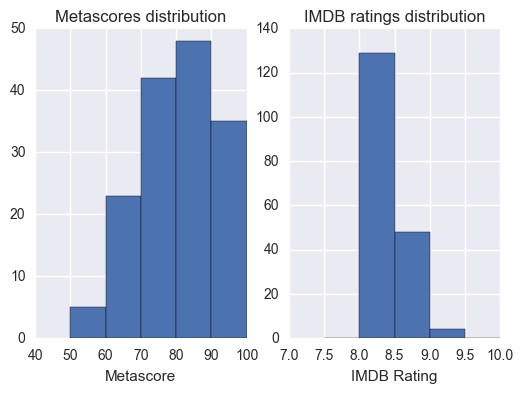

In [17]:
plt.subplot(1,2,1)
plt.hist(top_250['Metascore'], range=(40, 100), bins=6)
plt.xlabel('Metascore')
plt.title('Metascores distribution')

plt.subplot(1,2,2)
plt.hist(top_250['imdbRating'], range=(7, 10), bins=6)
plt.xlabel('IMDB Rating')
plt.title('IMDB ratings distribution')

plt.show()

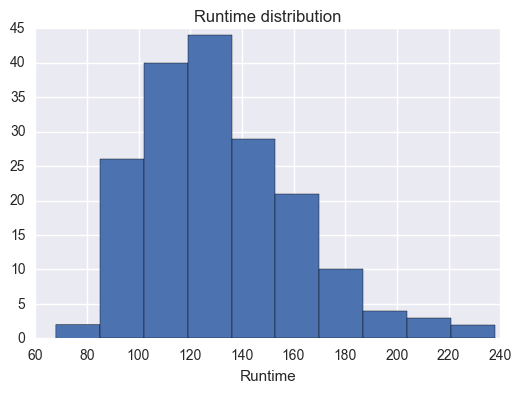

In [18]:
plt.hist(top_250['Runtime'])
plt.xlabel('Runtime')
plt.title('Runtime distribution')
plt.show()

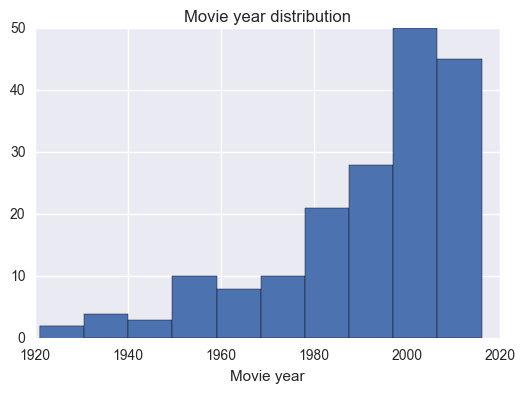

In [19]:
plt.hist(top_250['Year'])
plt.xlabel('Movie year')
plt.title('Movie year distribution')
plt.show()

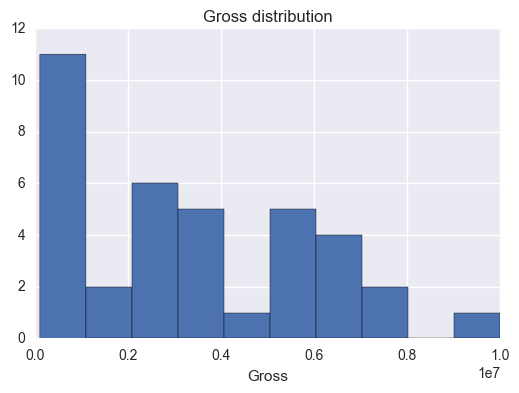

In [20]:
plt.hist(top_250['Gross'], range=(10e4, 10e6))
plt.xlabel('Gross')
plt.title('Gross distribution')
plt.show()

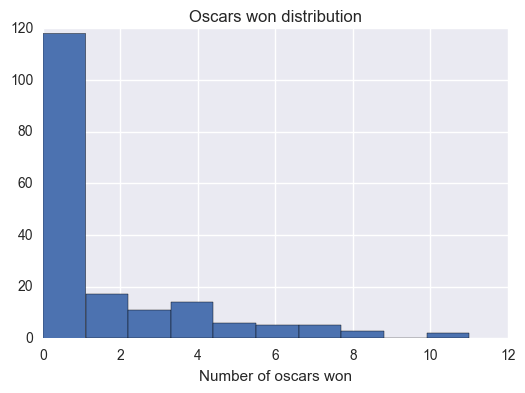

In [21]:
plt.hist(top_250['Oscars_won'])
plt.xlabel('Number of oscars won')
plt.title('Oscars won distribution')
plt.show()

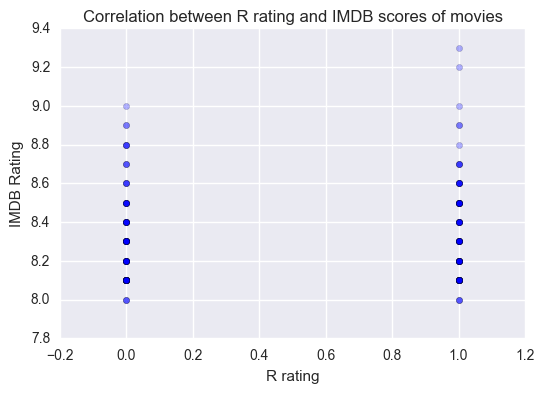

In [22]:
plt.scatter(top_250['Rated_R'], top_250['imdbRating'], alpha=0.3)
plt.xlabel('R rating')
plt.ylabel('IMDB Rating')
plt.title('Correlation between R rating and IMDB scores of movies')
plt.show()

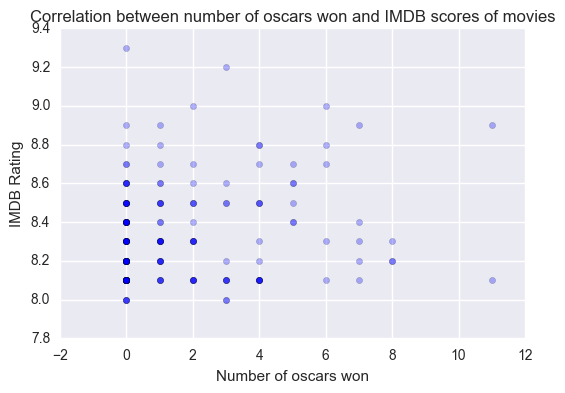

In [23]:
plt.scatter(top_250['Oscars_won'], top_250['imdbRating'], alpha=0.3)
plt.xlabel('Number of oscars won')
plt.ylabel('IMDB Rating')
plt.title('Correlation between number of oscars won and IMDB scores of movies')
plt.show()

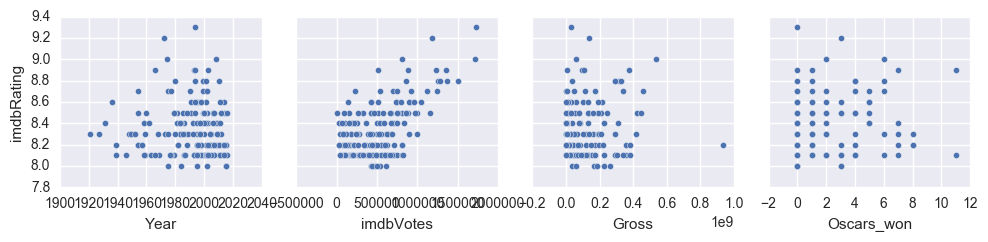

In [24]:
sns.pairplot(top_250, y_vars='imdbRating', x_vars=['Year', 'imdbVotes', 'Gross', 'Oscars_won'])

plt.show()

## 5. Data modeling - Comparison of several Tree models

### a. Define target and predictors

In [25]:
from sklearn.preprocessing import MinMaxScaler

X = top_250.drop(['Metascore', 'imdbRating', 'Director', 'Language', 'Plot', 'Released', 'Title', 'Writer'], axis = 1)
X[['Runtime', 'Year', 'imdbVotes', 'Gross']] = MinMaxScaler().fit_transform(X[['Runtime', 'Year', 'imdbVotes', 'Gross']])
X.head(2)

,Response,Runtime,Year,imdbVotes,Gross,Rated_G,Rated_M,Rated_NOT RATED,Rated_PASSED,Rated_PG,Rated_PG-13,Rated_R,Rated_UNRATED,Actors_aamir khan,Actors_al pacino,Actors_alec guinness,Actors_ben kingsley,Actors_brad pitt,Actors_bruce willis,Actors_carrie fisher,Actors_charles chaplin,Actors_charles vanel,Actors_charlton heston,Actors_christian bale,Actors_clint eastwood,Actors_faye dunaway,Actors_fred macmurray,Actors_gary oldman,Actors_george sanders,Actors_grace kelly,Actors_graham chapman,Actors_gunnar björnstrand,Actors_guy pearce,Actors_harrison ford,Actors_henry bergman,Actors_henry fonda,Actors_ho song,Actors_hugh jackman,Actors_hugo weaving,Actors_humphrey bogart,Actors_jack hawkins,Actors_jack nicholson,Actors_james stewart,Actors_joe pesci,Actors_leonardo dicaprio,Actors_mark hamill,Actors_marlon brando,Actors_matt damon,Actors_michael caine,Actors_morgan freeman,...,Country_ireland,Country_italy,Country_japan,Country_kong,Country_korea,Country_kuwait,Country_lebanon,Country_libya,Country_luxembourg,Country_mexico,Country_morocco,Country_new,Country_poland,Country_south,Country_soviet,Country_spain,Country_sweden,Country_switzerland,Country_taiwan,Country_turkey,Country_uk,Country_union,Country_united,Country_usa,Country_west,Country_zealand,Genre_action,Genre_adventure,Genre_animation,Genre_biography,Genre_comedy,Genre_crime,Genre_drama,Genre_family,Genre_fantasy,Genre_fi,Genre_film,Genre_history,Genre_horror,Genre_music,Genre_musical,Genre_mystery,Genre_noir,Genre_romance,Genre_sci,Genre_sport,Genre_thriller,Genre_war,Genre_western,Oscars_won
0,True,0.435294,0.768421,1.000000,0.030249,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,True,0.629412,0.536842,0.681975,0.143935,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3


In [26]:
y = top_250['imdbRating']
y.head()

0    9.3
1    9.2
2    9.0
3    9.0
5    8.9
Name: imdbRating, dtype: float64

As our sample is quite small (181 rows) we will use cross validation to assess models instead of splitting our data into training and test sets. We will test five different tree models and compare their cross-validated r2 scores.

In [27]:
#Define function to plot models prediction errors

from sklearn.cross_validation import KFold, cross_val_score

cv = KFold(len(y), shuffle=True)
model_scores = {}

def do_plot(model, m=None):
    for fold, color in zip(cv, ['r', 'g', 'b']):
        X_train = X.iloc[fold[0]]
        X_test  = X.iloc[fold[1]]
        y_train = y.iloc[fold[0]]
        y_test  = y.iloc[fold[1]]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        plt.scatter(y_test, y_pred, color=color)
        plt.plot([8,9.5],[8,9.5])
        plt.text(9,9.5, "R2: "+str(m), fontsize=20, )

/Users/chloe/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### b. Decistion Tree

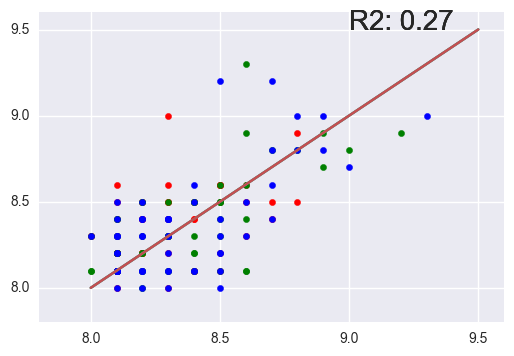

In [28]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor()

scores_dt = cross_val_score(dt, X, y, cv=cv)
model_scores['dt'] = {'model': dt,
                      'score': scores_dt.mean().round(2)}

do_plot(dt, scores_dt.mean().round(2))

{u'min_samples_split': 5, u'max_depth': 5, u'min_samples_leaf': 2}
0.315834261198


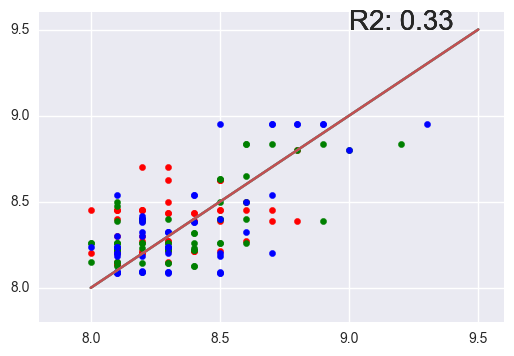

In [29]:
#Optimise decision tree model
from sklearn.model_selection import GridSearchCV

params = {'max_depth': [None, 5, 10],
          'min_samples_split': [2, 5],
          'min_samples_leaf': [1, 2, 3]}

gsdt = GridSearchCV(dt,
                    params, n_jobs=-1,
                    cv=cv)

gsdt.fit(X, y)
print gsdt.best_params_
print gsdt.best_score_

scores_gsdt = cross_val_score(gsdt.best_estimator_, X, y, cv=cv)
model_scores['gsdt'] = {'model': gsdt.best_estimator_,
                          'score': scores_gsdt.mean().round(2)}

do_plot(gsdt.best_estimator_, scores_gsdt.mean().round(2))

### c. Random Forest Regressor

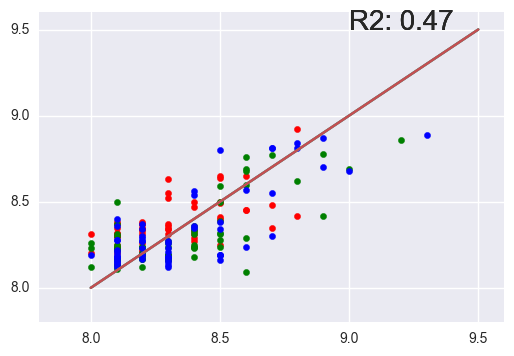

In [30]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()

scores_rf = cross_val_score(rf, X, y, cv=cv)
model_scores['rf'] = {'model': rf,
                      'score': scores_rf.mean().round(2)}

do_plot(rf, scores_rf.mean().round(2))

{u'min_samples_split': 5, u'n_estimators': 50, u'criterion': u'mae', u'max_depth': None}
0.530223807621


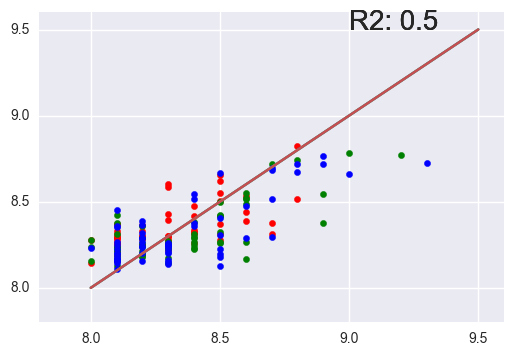

In [31]:
# Optimise model
params = {'n_estimators':[3, 5, 10, 50],
          'criterion': ['mse', 'mae'],
          'max_depth': [None, 3, 5],
          'min_samples_split': [2,5],}


gsrf = GridSearchCV(RandomForestRegressor(n_jobs=-1),
                    params, n_jobs=-1,
                    cv=cv)

gsrf.fit(X, y)

print gsrf.best_params_
print gsrf.best_score_

scores_gsrf = cross_val_score(gsrf.best_estimator_, X, y, cv=cv)
model_scores['gsrf'] = {'model': gsrf.best_estimator_,
                          'score': scores_gsrf.mean().round(2)}

do_plot(gsrf.best_estimator_, scores_gsrf.mean().round(2))

### d. Ada Boost Regressor

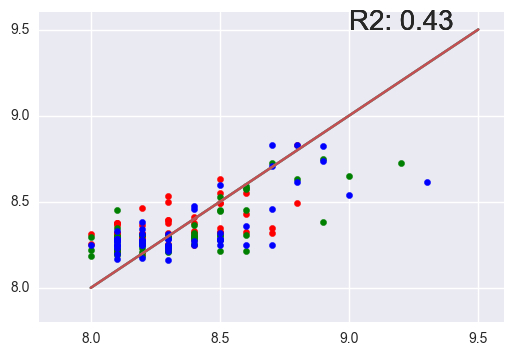

In [32]:
from sklearn.ensemble import AdaBoostRegressor

ab = AdaBoostRegressor()

scores_ab = cross_val_score(ab, X, y, cv=cv)
model_scores['ab'] = {'model': ab,
                      'score': scores_ab.mean().round(2)}

do_plot(ab, scores_ab.mean().round(2))

{u'n_estimators': 50, u'loss': u'square'}
0.454182171807


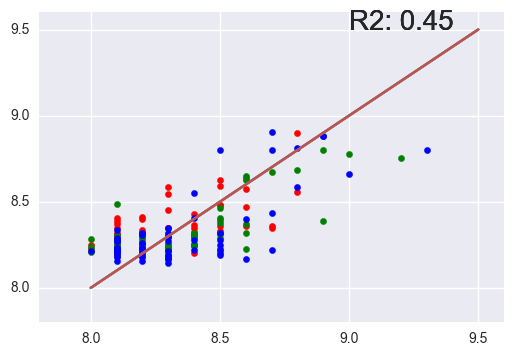

In [33]:
# Optimise model
params = {'n_estimators':[3, 5, 10, 50],
          'loss' : ['linear', 'square', 'exponential']}


gsab = GridSearchCV(AdaBoostRegressor(),
                    params, n_jobs=-1,
                    cv=cv)

gsab.fit(X, y)

print gsab.best_params_
print gsab.best_score_

scores_gsab = cross_val_score(gsab.best_estimator_, X, y, cv=cv)
model_scores['gsab'] = {'model': gsab.best_estimator_,
                          'score': scores_gsab.mean().round(2)}

do_plot(gsab.best_estimator_, scores_gsab.mean().round(2))

### c. Gradient Boosting Trees Regressor

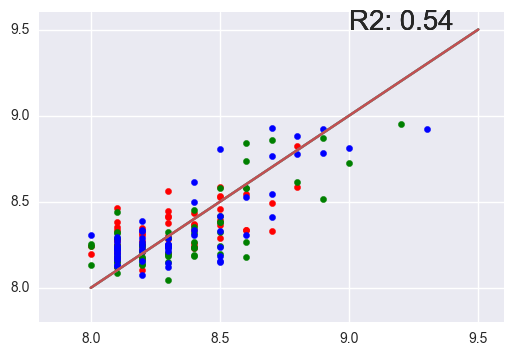

In [34]:
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor()

scores_gb = cross_val_score(gb, X, y, cv=cv)
model_scores['gb'] = {'model': gb,
                      'score': scores_gb.mean().round(2)}

do_plot(gb, scores_gb.mean().round(2))

{u'loss': u'huber', u'learning_rate': 0.1}
0.55119942146


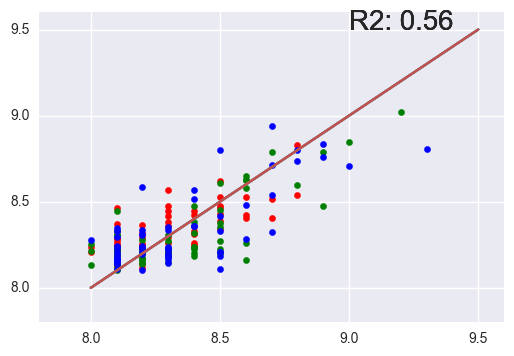

In [35]:
# Optimise model
params = {'loss': ['ls', 'lad', 'huber', 'quantile'],
         'learning_rate': [0.1, 1, 10]}


gsgb = GridSearchCV(GradientBoostingRegressor(),
                    params, n_jobs=-1,
                    cv=cv)

gsgb.fit(X, y)

print gsgb.best_params_
print gsgb.best_score_

scores_gsgb = cross_val_score(gsgb.best_estimator_, X, y, cv=cv)
model_scores['gsgb'] = {'model': gsgb.best_estimator_,
                          'score': scores_gsgb.mean().round(2)}

do_plot(gsgb.best_estimator_, scores_gsgb.mean().round(2))

### d. Extra Trees

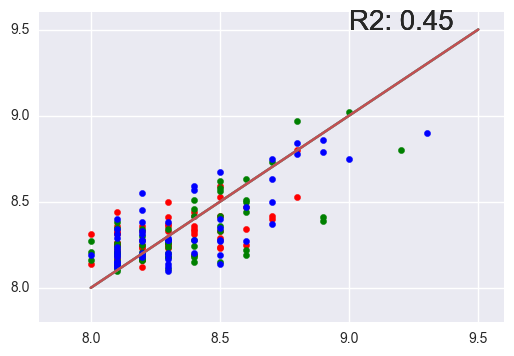

In [36]:
from sklearn.ensemble import ExtraTreesRegressor

et = ExtraTreesRegressor()

scores_et = cross_val_score(et, X, y, cv=cv)
model_scores['et'] = {'model': et,
                      'score': scores_et.mean().round(2)}

do_plot(et, scores_et.mean().round(2))

{u'min_samples_split': 2, u'n_estimators': 50, u'criterion': u'mae', u'max_depth': None}
0.534245150544


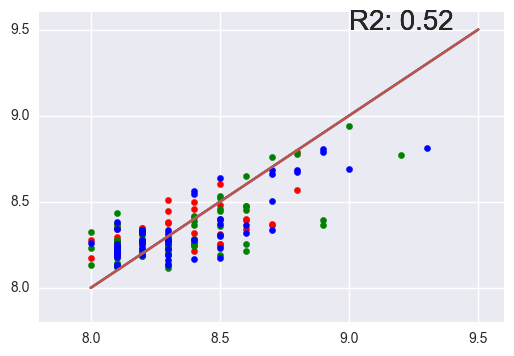

In [37]:
#Optimise model
params = {'n_estimators':[3, 5, 10, 50],
          'criterion': ['mse', 'mae'],
          'max_depth': [None, 3, 5],
          'min_samples_split': [2,5],}


gset = GridSearchCV(ExtraTreesRegressor(),
                    params, n_jobs=-1,
                    cv=cv)

gset.fit(X, y)

print gset.best_params_
print gset.best_score_

scores_gset = cross_val_score(gset.best_estimator_, X, y, cv=cv)
model_scores['gset'] = {'model': gset.best_estimator_,
                          'score': scores_gset.mean().round(2)}

do_plot(gset.best_estimator_, scores_gset.mean().round(2))

## 6. Models comparison

,score
model,
gsgb,0.56
gb,0.54
gset,0.52
gsrf,0.50
rf,0.47
et,0.45
gsab,0.45
ab,0.43
gsdt,0.33


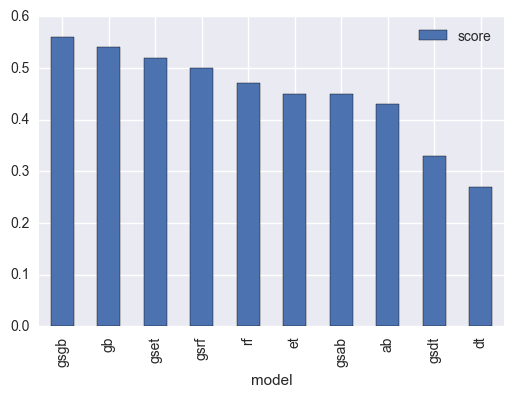

In [38]:
scores = pd.DataFrame([(k, v['score']) for k, v in model_scores.iteritems()],
             columns=['model', 'score']).set_index('model').sort_values('score', ascending=False)

scores.plot(kind='bar')

scores

In [39]:
#Retest all models  using a 3 fold stratified shuffled cross validation and compare them

from sklearn.cross_validation import StratifiedKFold

def retest(model):
    scores = cross_val_score(model, X, y,
                             cv=StratifiedKFold(y, shuffle=True),
                             n_jobs=-1)
    m = scores.mean()
    s = scores.std()
    
    return m, s

for k, v in model_scores.iteritems():
    cvres = retest(v['model']) 
    model_scores[k]['cvres'] = cvres
    

/Users/chloe/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:532: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)


,score,error
model,,
gb,0.569511,0.084289
rf,0.549499,0.091587
gsgb,0.505264,0.085589
gsrf,0.503808,0.053801
ab,0.460640,0.041831
gsab,0.434186,0.024725
gset,0.411599,0.138841
dt,0.324218,0.163064
et,0.313470,0.067219


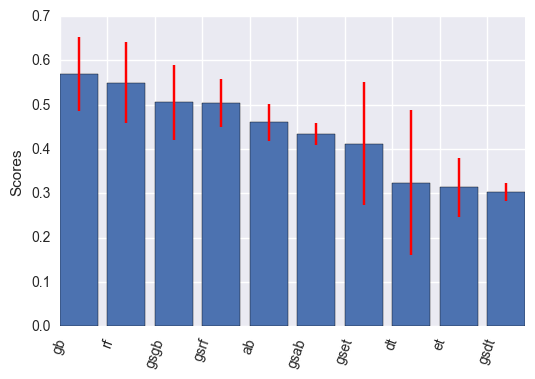

In [40]:
cvscores = pd.DataFrame([(k, v['cvres'][0], v['cvres'][1] ) for k, v in model_scores.iteritems()],
                        columns=['model', 'score', 'error']).set_index('model').sort_values('score', ascending=False)



fig, ax = plt.subplots()
rects1 = ax.bar(range(len(cvscores)), cvscores.score,
                yerr=cvscores.error, ecolor='r',
                tick_label=cvscores.index)

ax.set_ylabel('Scores')
plt.xticks(rotation=70)
plt.plot()

cvscores

The most stable model with the highest score is therefore the optimised Random Forest Regressor. We will check the importance of each feature with this model.

(-1, 30)

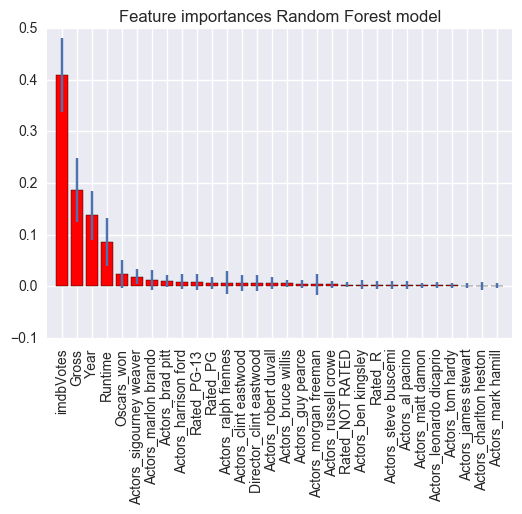

In [43]:
# Get feature importance from random forest model

importances_rf = gsrf.best_estimator_.feature_importances_
std_rf = np.std([tree.feature_importances_ for tree in gsrf.best_estimator_.estimators_], axis=0)

indices_rf = np.argsort(importances_rf)[::-1]
feature_names = X.columns

# Plot the feature importances (top 30 only) of the optimised random forest model
plt.figure()
plt.title("Feature importances Random Forest model")
plt.bar(range(30), importances_rf[indices_rf][:30],
       color="r", yerr=std_rf[indices_rf][:30], align="center")
plt.xticks(range(30), feature_names[indices_rf][:30], rotation=90)
plt.xlim([-1, 30])

The most important features in the random forest regression model are: imdb votes, gross, year and runtime. Other features do not have a significant importance.

(-1, 30)

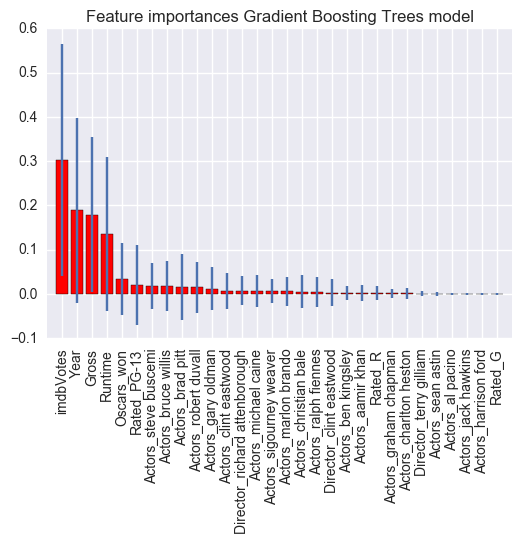

In [44]:
# Check if gradient boosting regressor gives similar results 
importances = gb.feature_importances_
std = np.std([tree[0].feature_importances_ for tree in gb.estimators_], axis=0)

indices = np.argsort(importances)[::-1]

# Plot the feature importances (top 30 only) of the optimised gb model
plt.figure()
plt.title("Feature importances Gradient Boosting Trees model")
plt.bar(range(30), importances[indices][:30],
       color="r", yerr=std[indices][:30], align="center")
plt.xticks(range(30), feature_names[indices][:30], rotation=90)
plt.xlim([-1, 30])

Gradient boosting results are consistent with random forest altough much less stable.

In summary the best predictors of a movie's success (high imdb score) seem to be imdb votes, gross, year and runtime.

## Blog post

https://chloepont.github.io/top_250_movies/